In [135]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [136]:
# Data Load

# load the given data from the url below
energy_data = 'https://raw.githubusercontent.com/timkim0713/electricity-usage-prediction-model/master/energy_data.csv'
weather_data = 'https://raw.githubusercontent.com/timkim0713/electricity-usage-prediction-model/master/weather_data.csv'


# PART I: A. ENERGY DATA PROCESSING
- Drop unnecessary data & change the time inteverval to "per day" and add up 48 sub-divided "use [kW]"" data into one day.

- use only 'date & time' & 'use [kW]' columns from energy data. 
---
- Observed Missing Data Found by counting the number of data given per day
- Missing Data Observed at --> **2014-03-09 02:00:00 & 2014-03-09 02:30:00**
- Filled Above '[use kW]' Missing Data for above with linear interpolation


---


- Observed Duplicate Data of Time/Date Label at **2014-11-02 01:00:00, 01:30:00**
- Dropped 2 data at 2014-11-02 01:00:00, 2014-11-02 01:30:00

In [137]:
# ENERGY DATA PROCESSING
# Drop unnecessary data & change the time inteverval to "per day" and add up 48 sub-divided "use [kW]"" data into one day.

# Read data
df_e = pd.read_csv(energy_data)

# use only 'date & time' & 'use [kW]' columns from energy data. 
df_e_filtered =df_e[['Date & Time','use [kW]']]

#Observed Missing Data Found by counting the number of data given per day
#Missing Data --> 2014-03-09 02:00:00, 2014-03-09 02:30:00
#print(df_e_filtered[3218:3221])

# Add Missing Data 
df_e_filtered.loc[3219.5] = '2014-03-09 02:00:00', None
df_e_filtered.loc[3219.6] = '2014-03-09 02:30:00', None
# Sort Index from 0
df_e_filtered = df_e_filtered.sort_index().reset_index(drop=True)
# Used Linear Interpolation to Fill Missing Data we set above (2014-03-09 02:00:00, 2014-03-09 02:30:00) 
df_e_filtered['use [kW]'].interpolate(method = 'linear', inplace = True)
print("Added Missing Data Value at 2014-03-09 02:00:00, 2014-03-09 02:30:00 using Linear Interpolation with values as below")

# check below
print(df_e_filtered[3220:3222], '\n')


# Rename Date & Time column to date
df_e_filtered['date']=df_e_filtered['Date & Time']


#Observed 2014-11-02 01:00:00, 01:30:00  DUPLICATE DATA!
print("Observed Duplicate Data of Time/Date Label at 2014-11-02 01:00:00, 01:30:00")

print("Data Size BEFORE duplicate: ",df_e_filtered['date'].size)
df_e_filtered = df_e_filtered.drop_duplicates(subset=['date'])
print("Data Size AFTER duplicate: ",df_e_filtered['date'].size)
print("Dropped 2 data at 2014-11-02 01:00:00, 2014-11-02 01:30:00\n")

# reset index from 0 for dropped indicies
df_e_filtered.reset_index(drop=True, inplace=True)


df_e_filtered['date'] = pd.to_datetime(df_e_filtered['Date & Time'],  format='%Y-%m-%d')
# # 48 is the number we use to calculate "per day" from given time interval, 
# #thus data results in size of 365 after dividing up the data by 48.
d = {'date': 'first', 'use [kW]': 'sum'}
df_e_processed = df_e_filtered.groupby(df_e_filtered.index // 48).agg(d)

df_e_processed.head()

Added Missing Data Value at 2014-03-09 02:00:00, 2014-03-09 02:30:00 using Linear Interpolation with values as below
              Date & Time  use [kW]
3220  2014-03-09 02:00:00  0.263443
3221  2014-03-09 02:30:00  0.227414 

Observed Duplicate Data of Time/Date Label at 2014-11-02 01:00:00, 01:30:00
Data Size BEFORE duplicate:  17522
Data Size AFTER duplicate:  17520
Dropped 2 data at 2014-11-02 01:00:00, 2014-11-02 01:30:00



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,date,use [kW]
0,2014-01-01,65.013592
1,2014-01-02,32.305336
2,2014-01-03,31.164468
3,2014-01-04,45.287782
4,2014-01-05,36.316643


# PART I: B. WEATHER DATA PROCESSING
- Changed time format to match energy data's date/time & changed with unit 's'
- Checked for null data in weather & **Observed 1470 null data in cloudCover **
- Handled above with linear interpolation to fill up the data
--- 
- Mapped the time interval into one day, using average for all the numerical data, mode for string values.
- The interval is divided into 24 to change into one day interval. 



In [138]:
# WEATHER DATA PROCESSING
df_w = pd.read_csv(weather_data)
# format given time to match energy date/time & change unit
df_w['date'] = pd.to_datetime(df_w['time'],unit='s')

# check for null data in weather, observe 1470 null in cloudCover
print(df_w.isnull().sum())
print("Observed 1470 null cloudCover data rows.\n-----------------------------------------------")
print("Handling the null data with linear interpolation")
# Using linear regression interpolation to fill the empty data.
df_w['cloudCover'].interpolate(method = 'linear', inplace = True)
print(df_w.isnull().sum())
print("Done.")

# Mapping of average of "per day" interval with average for the all the numerical data, mode for string values, 
# & time is set into day interval (chosen with first index every 24 data).
d = {'date': 'first', 'temperature':'mean', 'icon':lambda x:x.value_counts().index[0], 'humidity':'mean', 'visibility':'mean',
     'summary':lambda x:x.value_counts().index[0], 'pressure':'mean', 'windSpeed':'mean','cloudCover':'mean', 'windBearing':'mean', 'precipIntensity':'mean','dewPoint':'mean',
     'precipProbability':'mean'}


df_w_processed = df_w.groupby(df_w.index // 24).agg(d)
df_w_processed.head()



temperature             0
icon                    0
humidity                0
visibility              0
summary                 0
pressure                0
windSpeed               0
cloudCover           1470
time                    0
windBearing             0
precipIntensity         0
dewPoint                0
precipProbability       0
date                    0
dtype: int64
Observed 1470 null cloudCover data rows.
-----------------------------------------------
Handling the null data with linear interpolation
temperature          0
icon                 0
humidity             0
visibility           0
summary              0
pressure             0
windSpeed            0
cloudCover           0
time                 0
windBearing          0
precipIntensity      0
dewPoint             0
precipProbability    0
date                 0
dtype: int64
Done.


,date,temperature,icon,humidity,visibility,summary,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01,20.110833,clear-night,0.556667,9.970000,Clear,1025.395000,6.820417,0.030000,252.291667,0.000000,6.362083,0.000000
1,2014-01-02,16.382500,snow,0.784583,3.834583,Light Snow,1023.465833,7.433750,0.757917,53.458333,0.002004,10.737083,0.074583
2,2014-01-03,6.256667,snow,0.680833,4.509167,Light Snow,1014.428750,12.828333,0.585417,207.333333,0.002029,-2.337500,0.080000
3,2014-01-04,2.711667,clear-night,0.617083,9.822917,Clear,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000
4,2014-01-05,17.654167,clear-night,0.682083,9.134583,Clear,1025.275000,3.417083,0.072083,208.958333,0.000033,8.615000,0.000417


# PART I: C. Merge Energy Data into Weather Data

- Checked the shape of merged data: 365x14


In [139]:
# Merge Energy Data into Weather Data

# Merge Energy into Weather
df = df_w_processed.merge(df_e_processed)
# df = pd.concat([df_w_processed, df_e_processed] )

# reorder columns
columns_titles = ['date', 'use [kW]', 'temperature', 'icon', 'summary', 'visibility', 'humidity', 'pressure', 'windSpeed', 'cloudCover', 'windBearing','dewPoint','precipIntensity', 'precipProbability']
merged_df = df.reindex(columns=columns_titles)
print("Size of Data: ",merged_df.shape)
merged_df.head()

Size of Data:  (365, 14)


,date,use [kW],temperature,icon,summary,visibility,humidity,pressure,windSpeed,cloudCover,windBearing,dewPoint,precipIntensity,precipProbability
0,2014-01-01,65.013592,20.110833,clear-night,Clear,9.970000,0.556667,1025.395000,6.820417,0.030000,252.291667,6.362083,0.000000,0.000000
1,2014-01-02,32.305336,16.382500,snow,Light Snow,3.834583,0.784583,1023.465833,7.433750,0.757917,53.458333,10.737083,0.002004,0.074583
2,2014-01-03,31.164468,6.256667,snow,Light Snow,4.509167,0.680833,1014.428750,12.828333,0.585417,207.333333,-2.337500,0.002029,0.080000
3,2014-01-04,45.287782,2.711667,clear-night,Clear,9.822917,0.617083,1030.096250,5.248333,0.001667,240.166667,-8.352083,0.000000,0.000000
4,2014-01-05,36.316643,17.654167,clear-night,Clear,9.134583,0.682083,1025.275000,3.417083,0.072083,208.958333,8.615000,0.000033,0.000417


# **PART II: Training/Test Dataset**
Goal is on predicting each day of December, so Jan - Nov data are split into training/test dataset with 8:2 ratio.
---
- Jan - Nov Training/Test Score:  0.2666596060081261
- Model Score on December:  -0.5972748944608137
- Root Mean Squared Error on December Evaluation:  8.968926005862448
- Exported CSV with 2 columns: date, predicted use [kW]


In [140]:
# Goal is on predicting each day of December, so split Jan - Nov data are split into training/test dataset with 8:2 raito.
# 0 - 333 is Jan - Nov, otherwise December
X = merged_df.drop("icon",axis=1)
X = X.drop("summary", axis=1)
X = X.drop("date",axis=1)
X = X.drop("use [kW]",axis=1)

X= X[:334] 
y = merged_df['use [kW]'][:334]

december_original_df = merged_df[334:]

december_df = merged_df[334:]
december_df = december_df.drop('icon', axis=1)
december_df = december_df.drop("summary", axis=1)
december_df = december_df.drop("date",axis=1)
december_df = december_df.drop("use [kW]",axis=1)

# # Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=200)
  
# drop use [kW] column in test dataset
# test = test.drop('use [kW]', 1)

# PART III: Linear Regression - Predicting Energy Usage

How well/badly does the model work? (Evaluate the correctness of
your predictions based on the original “use [kW]” column). Calculate the Root mean squared error
of your model.



In [141]:
model = LinearRegression().fit(X_train, y_train)
print("Jan - Nov Training/Test Score: ", model.score(X_train, y_train))

december_predicted_use_kw = model.predict(december_df)
print("Model Score on December: ",model.score(december_df, december_original_df['use [kW]']))
# 
print("Root Mean Squared Error on December Evaluation: ", mean_squared_error(december_original_df['use [kW]'], december_predicted_use_kw, squared=False))


# Exporting CSV Data Date, use [kW] 
data = {'date': december_original_df['date'].dt.strftime('%Y-%m-%d'),
        'predicted use [kW]': december_predicted_use_kw,
        # 'actual use [kW]': december_original_df['use [kW]'].to_numpy()
        }
csv_df = pd.DataFrame(data, columns= ['date', 'predicted use [kW]'])#'actual use [kW]'
# print(csv_df)
csv_df.to_csv(r'./cse351_hw2_kim_daekyung_110887867_linear_regression.csv',index = False)
print("Exported CSV with 2 columns: date, predicted use [kW]")


Jan - Nov Training/Test Score:  0.2666596060081261
Model Score on December:  -0.5972748944608137
Root Mean Squared Error on December Evaluation:  8.968926005862448
Exported CSV with 2 columns: date, predicted use [kW]


# PART IV. Logistic Regression - Temperature classification
- Divided up Jan-Nov / Dec
- Ran Logistic Regression on temperature data (1: >=35, 0:< 35)
- Score below in the output
---
- Jan - Nov Training/Test Score for temperature:  0.9700374531835206
- Model Score on December Temperature:  0.6129032258064516
- F1 Score of December Temperature Prediction:  0.6666666666666667

In [142]:
# temp >= 35 high, <35 is low

# december_original_df.drop('temperature', axis=1)
# clf = LogisticRegression(random_state=0).fit()
THRESHOLD = 35

temperature_df =merged_df.drop('icon',axis=1).drop('summary',axis=1).drop('date',axis=1)
temperature_december_df = temperature_df[334:]
temperature_df = temperature_df[:334]
temperature_df['temperature'] = (temperature_df['temperature'] >= THRESHOLD).astype(int)


temperature_only_df = temperature_df['temperature'][:334]
temperature_df = temperature_df.drop('temperature',axis=1)[:334]
X= temperature_df
y =temperature_only_df
# # Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=200)

temperature_model = LogisticRegression().fit(X_train, y_train)
print("Jan - Nov Training/Test Score for temperature: ", temperature_model.score(X_train, y_train))


# December Temperature Data for Prediction
december_temperature_df = merged_df.drop('icon',axis=1).drop('summary',axis=1)[334:]
december_temperature_with_date_df = december_temperature_df
december_temperature_df = december_temperature_with_date_df.drop('date',axis=1)
december_temperature_original_df = (december_temperature_df['temperature']>= THRESHOLD).astype(int)
december_temperature_df = december_temperature_df.drop('temperature',axis=1)

december_predicted_temperature = temperature_model.predict(december_temperature_df)

print("Model Score on December Temperature: ",temperature_model.score(december_temperature_df, december_temperature_original_df))
print("F1 Score of December Temperature Prediction: ", f1_score(december_temperature_original_df, december_predicted_temperature, average='binary'))



Jan - Nov Training/Test Score for temperature:  0.9700374531835206
Model Score on December Temperature:  0.6129032258064516
F1 Score of December Temperature Prediction:  0.6666666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [143]:
# CSV Export
data = {'date': december_temperature_with_date_df['date'].dt.strftime('%Y-%m-%d'),
        'predicted classification': december_predicted_temperature
        #'actual classification': december_temperature_original_df
        }
csv_df = pd.DataFrame(data, columns= ['date', 'predicted classification'])#'actual temperature'
# print(csv_df)
csv_df.to_csv(r'./cse351_hw2_kim_daekyung_110887867_logistic_regression.csv',index = False)
print("Exported CSV with 2 columns: date, predicted classification")

Exported CSV with 2 columns: date, predicted classification


# PART V: Energy Usage Data Analysis (Data Processing)

In [144]:
df_e = pd.read_csv(energy_data)

# Add Missing Data 
df_e.loc[3219.5] = '2014-03-09 02:00:00', None ,None ,None ,None ,None ,None ,None ,None ,None ,None ,None ,None, None ,None ,None ,None, None
df_e.loc[3219.6] = '2014-03-09 02:30:00', None ,None ,None ,None ,None ,None ,None ,None ,None ,None ,None ,None, None, None, None, None, None
# Sort Index from 0
df_e = df_e.sort_index().reset_index(drop=True)
# Used Linear Interpolation to Fill Missing Data we set above (2014-03-09 02:00:00, 2014-03-09 02:30:00) 
df_e.interpolate(method = 'linear', inplace = True)
print("Added Missing Data Value at 2014-03-09 02:00:00, 2014-03-09 02:30:00 using Linear Interpolation with values")

#Observed 2014-11-02 01:00:00, 01:30:00  DUPLICATE DATA!
print("Observed Duplicate Data of Time/Date Label at 2014-11-02 01:00:00, 01:30:00")
df_e = df_e.drop_duplicates(subset=['Date & Time'])
print("Handled Data Processing mentioned above.")

Added Missing Data Value at 2014-03-09 02:00:00, 2014-03-09 02:30:00 using Linear Interpolation with values
Observed Duplicate Data of Time/Date Label at 2014-11-02 01:00:00, 01:30:00
Handled Data Processing mentioned above.


# PART V. A: Is the washer being used only during the day?

- Graph indicates that the washer is more used in the daytime than nighttime. (Peaking at 14:00-16:00). And we can see that there is little use midnight to the morning, and moderate usage compared to other times at evening.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


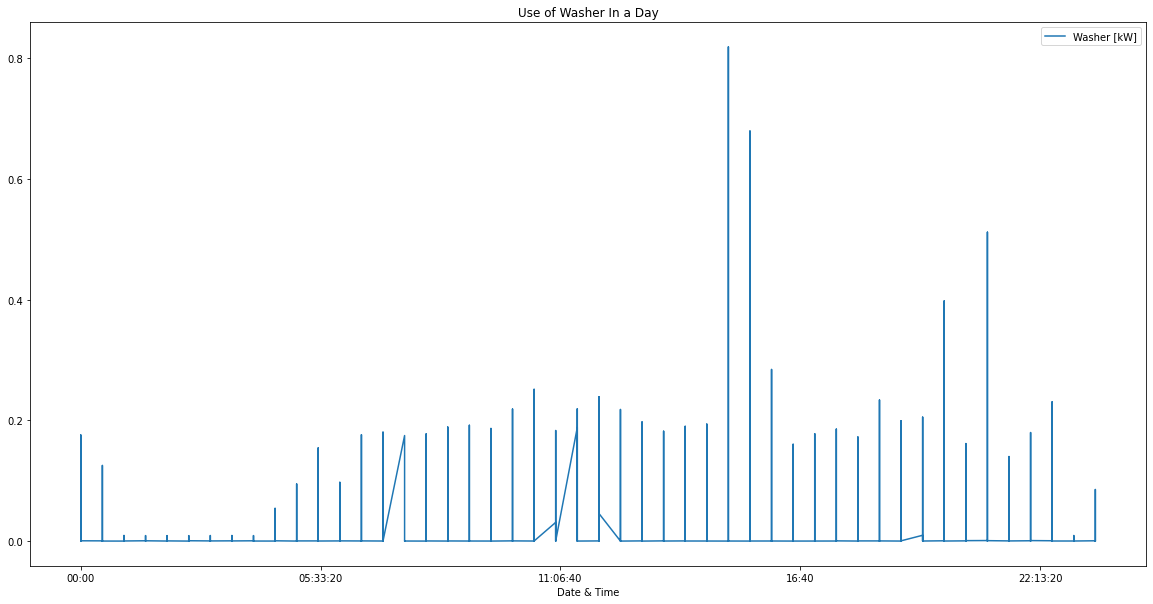

In [145]:

df_e_washer = df_e[['Washer [kW]', 'Date & Time']]
df_e_washer['Date & Time'] =  pd.to_datetime(df_e_washer['Date & Time']).dt.time
df_e_washer.set_index('Date & Time').plot(figsize=(20, 10), title="Use of Washer In a Day")

# PART V. B: During which month is the AC used most?
- Graph indicates below that the summmer season, (June - Oct), the AC was most used. We can observe no usage of AC in the winter season (Nov - Feb).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


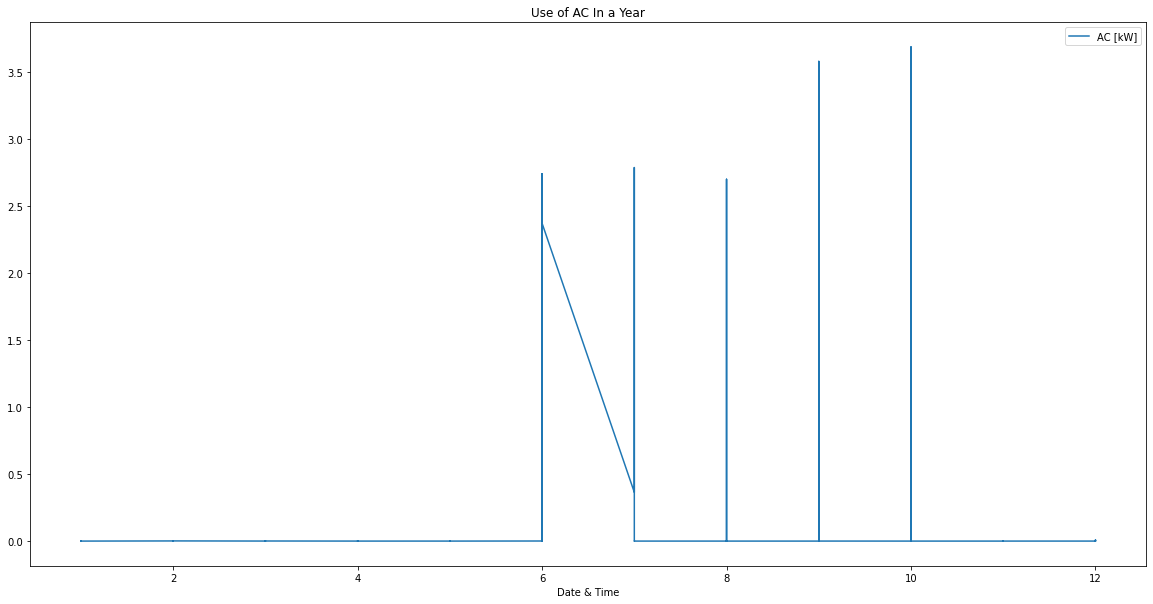

In [146]:

df_e_ac = df_e[['AC [kW]', 'Date & Time']]
df_e_ac['Date & Time'] =  pd.to_datetime(df_e_ac['Date & Time']).dt.month
df_e_ac.set_index('Date & Time').plot(figsize=(20, 10), title="Use of AC In a Year")


# Part V. C: Use of Dining Room (R) [kW] In a Day
- We can conclude that use of Dining Room in a day is high at lunch around (11:00 - 1:00) time & at dinner time around (17:00 - 19:00). This can be observed by comparing the visualized data to the other times in a day below. We can also observe no use of dining room at late midnight (1:00 AM) to early morning (4:00 AM).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


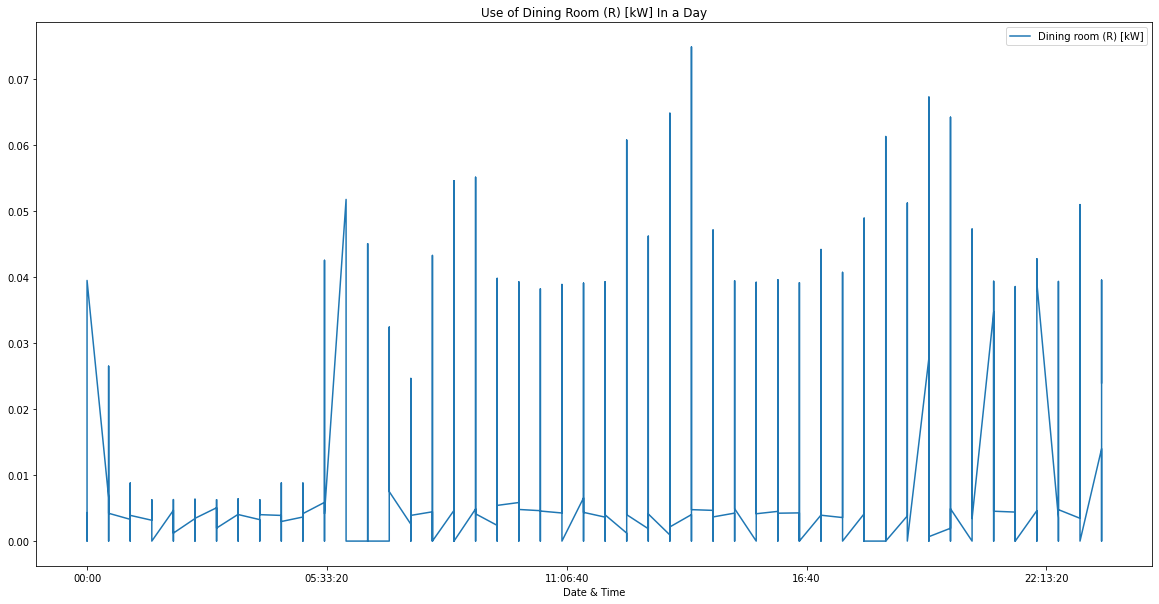

In [147]:
df_e_ac = df_e[['Dining room (R) [kW]', 'Date & Time']]
df_e_ac['Date & Time'] =  pd.to_datetime(df_e_ac['Date & Time']).dt.time
df_e_ac.set_index('Date & Time').plot(figsize=(20, 10), title="Use of Dining Room (R) [kW] In a Day")


# Part V. D: Use of Garage Outlets [kW] In a Day
- We can conclude that Use of Garage Outlets in a day is high at times in the morning (8:00 - 9:00) and afternoon (16:00 - 18:00) when most people leave their houses and return from work. This can be observed compared to the other times in a day in the graph below.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


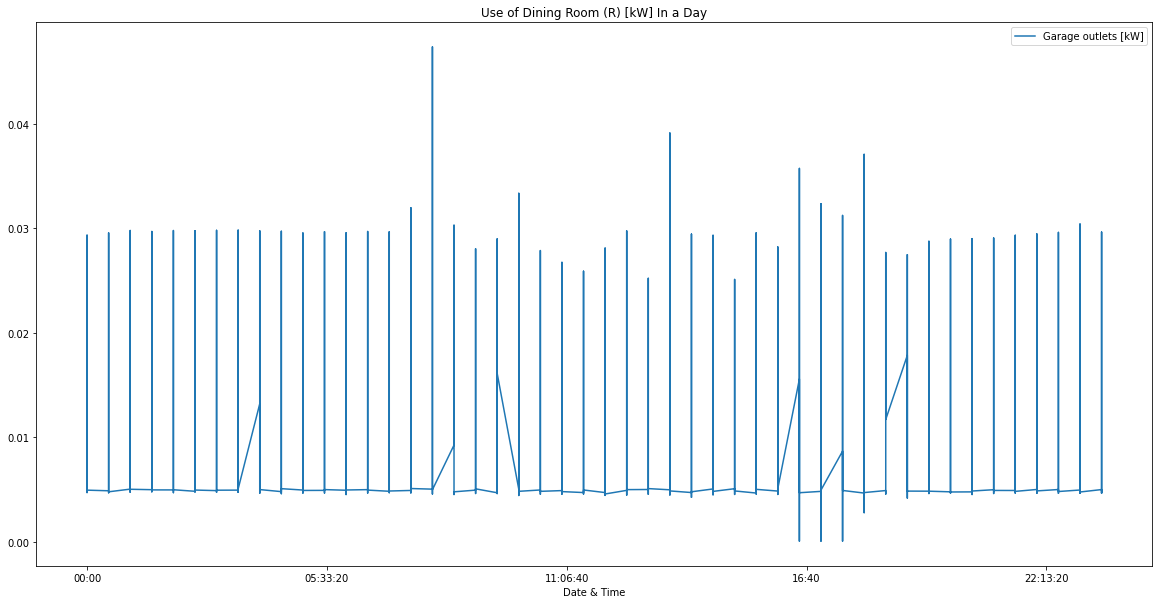

In [148]:
df_e_go = df_e[['Garage outlets [kW]', 'Date & Time']]
df_e_go['Date & Time'] =  pd.to_datetime(df_e_go['Date & Time']).dt.time
df_e_go.set_index('Date & Time').plot(figsize=(20, 10), title="Use of Dining Room (R) [kW] In a Day")
